# Data Augmentation Vs. No Data Augmentation

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import keras_tuner
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import matplotlib.patches as patches

2024-04-21 18:17:17.803343: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 18:17:17.803426: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 18:17:17.803487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-21 18:17:17.815021: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the Data

In [2]:
#load the data
with open("/share/jcorner_data/pkls/new_mode_svrimg/svrimg_new_mode_train.pkl", "rb") as f:
    (x_train, y_train) = pickle.load(f)

with open("/share/jcorner_data/pkls/new_mode_svrimg/svrimg_new_mode_validation.pkl", "rb") as f:
    (x_val, y_val) = pickle.load(f)

with open("/share/jcorner_data/pkls/new_mode_svrimg/svrimg_new_mode_test.pkl", "rb") as f:
    (x_test, y_test) = pickle.load(f)

num_classes = 4
input_shape = (136, 136, 1)

In [3]:
#Normalize by 80 dBZ
x_train = x_train.astype("float32") / 80
x_test = x_test.astype("float32") / 80
x_val = x_val.astype("float32") / 80

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validate samples")
print(x_test.shape[0], "test samples")

x_train shape: (4560, 136, 136, 1)
4560 train samples
309 validate samples
920 test samples


In [4]:
#convert to useful information for keras
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
gpus

2024-04-21 18:17:20.768976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 18:17:20.777279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 18:17:20.777408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Create the Model

In [6]:
def create_model():

    model = keras.Sequential(
        [
            keras.Input(shape=(136, 136, 1)),
            layers.Conv2D(12, kernel_size=(9, 9), activation="relu"),
            layers.Conv2D(24, kernel_size=(9, 9), activation="relu"),
            layers.AveragePooling2D(pool_size=(5, 5)),
            layers.Conv2D(48, kernel_size=(9, 9), activation="relu"),
            layers.AveragePooling2D(pool_size=(5, 5)),
            layers.Flatten(),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model 
    
model1 = create_model()
model2 = create_model()

2024-04-21 18:17:20.805861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 18:17:20.805999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 18:17:20.806101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
#rotate/zoom into images to reduce overfitting
datagen = ImageDataGenerator(rotation_range=55, zoom_range=[0.9,1.0], fill_mode="reflect")

### Compile the Two Models

In [8]:
model1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
history1 = model1.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=30, validation_data=(x_val, y_val), workers=8)


Epoch 1/30


2024-04-21 18:17:22.272001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-04-21 18:17:22.615560: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff640dd98e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-21 18:17:22.615604: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GRID A100X-10C, Compute Capability 8.0
2024-04-21 18:17:22.622222: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-21 18:17:22.700378: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 [==============================] - 7s 31ms/step - loss: 0.9019 - accuracy: 0.6140 - val_loss: 0.8141 - val_accuracy: 0.6602
Epoch 2/30
143/143 [==============================] - 5s 32ms/step - loss: 0.6869 - accuracy: 0.7171 - val_loss: 0.5409 - val_accuracy: 0.7929
Epoch 3/30
143/143 [==============================] - 5s 30ms/step - loss: 0.6147 - accuracy: 0.7515 - val_loss: 0.5024 - val_accuracy: 0.7896
Epoch 4/30
143/143 [==============================] - 5s 31ms/step - loss: 0.5422 - accuracy: 0.7886 - val_loss: 0.6397 - val_accuracy: 0.7055
Epoch 5/30
143/143 [==============================] - 4s 30ms/step - loss: 0.5010 - accuracy: 0.7958 - val_loss: 0.3898 - val_accuracy: 0.8447
Epoch 6/30
143/143 [==============================] - 5s 31ms/step - loss: 0.4452 - accuracy: 0.8239 - val_loss: 0.7590 - val_accuracy: 0.6667
Epoch 7/30
143/143 [==============================] - 5s 31ms/step - loss: 0.3989 - accuracy: 0.8397 - val_loss: 0.3446 - val_accuracy: 0.8770
Epoch 8/30

2024-04-21 18:18:10.096006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: TypeError: 'NoneType' object is not subscriptable
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/data_utils.py", line 871, in get
    raise e

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/data_utils.py", line 862, in get


143/143 [==============================] - 4s 30ms/step - loss: 0.3320 - accuracy: 0.8743 - val_loss: 0.2975 - val_accuracy: 0.8932
Epoch 11/30
143/143 [==============================] - 5s 31ms/step - loss: 0.3169 - accuracy: 0.8787 - val_loss: 0.2026 - val_accuracy: 0.9353
Epoch 12/30
143/143 [==============================] - 4s 30ms/step - loss: 0.2802 - accuracy: 0.8871 - val_loss: 0.2023 - val_accuracy: 0.9191
Epoch 13/30
143/143 [==============================] - 5s 31ms/step - loss: 0.2768 - accuracy: 0.8914 - val_loss: 0.2776 - val_accuracy: 0.8932
Epoch 14/30
143/143 [==============================] - 5s 31ms/step - loss: 0.2509 - accuracy: 0.9009 - val_loss: 0.1759 - val_accuracy: 0.9191
Epoch 15/30
143/143 [==============================] - 5s 31ms/step - loss: 0.2307 - accuracy: 0.9171 - val_loss: 0.1716 - val_accuracy: 0.9353
Epoch 16/30
143/143 [==============================] - 5s 30ms/step - loss: 0.2282 - accuracy: 0.9099 - val_loss: 0.1675 - val_accuracy: 0.9320
Epoc

In [9]:
model2.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
history2 = model2.fit(x_train, y_train,
                    epochs=30, validation_data=(x_val, y_val), workers=8)


2024-04-21 18:20:07.445691: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 337367040 exceeds 10% of free system memory.
2024-04-21 18:20:07.920918: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 337367040 exceeds 10% of free system memory.


Epoch 1/30
143/143 [==============================] - 2s 10ms/step - loss: 0.7927 - accuracy: 0.6649 - val_loss: 0.5980 - val_accuracy: 0.7443
Epoch 2/30
143/143 [==============================] - 1s 8ms/step - loss: 0.5614 - accuracy: 0.7805 - val_loss: 0.4961 - val_accuracy: 0.7994
Epoch 3/30
143/143 [==============================] - 1s 8ms/step - loss: 0.4769 - accuracy: 0.8125 - val_loss: 0.3500 - val_accuracy: 0.8544
Epoch 4/30
143/143 [==============================] - 1s 8ms/step - loss: 0.4088 - accuracy: 0.8445 - val_loss: 0.2657 - val_accuracy: 0.9159
Epoch 5/30
143/143 [==============================] - 1s 8ms/step - loss: 0.3293 - accuracy: 0.8752 - val_loss: 0.3724 - val_accuracy: 0.8673
Epoch 6/30
143/143 [==============================] - 1s 8ms/step - loss: 0.3056 - accuracy: 0.8846 - val_loss: 0.2240 - val_accuracy: 0.9223
Epoch 7/30
143/143 [==============================] - 1s 8ms/step - loss: 0.2444 - accuracy: 0.9066 - val_loss: 0.2274 - val_accuracy: 0.9126
Epoch

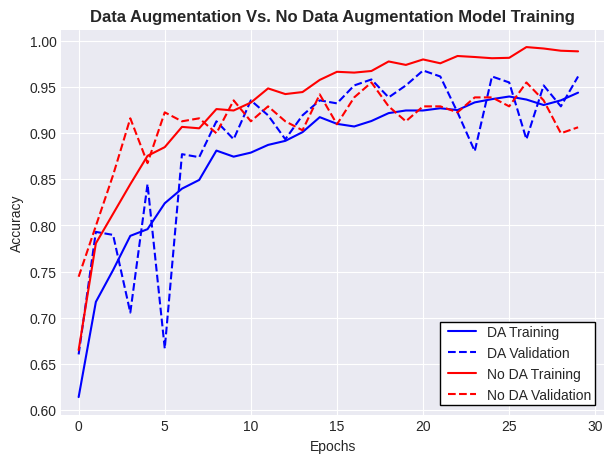

In [15]:
fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

# Change the style of plot
plt.style.use('seaborn-v0_8-darkgrid')

#plot the DA data
plt.plot(history1.history['accuracy'], color = 'blue')
plt.plot(history1.history['val_accuracy'], color = 'blue', linestyle='--')

#plot the none DA data
plt.plot(history2.history['accuracy'], color = 'red')
plt.plot(history2.history['val_accuracy'], color = 'red', linestyle='--')

#Set axis/plot titles
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Data Augmentation Vs. No Data Augmentation Model Training')
ax.set_xlim(-1, 30.5)

#create a legend
legend = ax.legend(['DA Training', 'DA Validation', 'No DA Training', 'No DA Validation'], loc='lower right', edgecolor =  'black')
# Create a Rectangle patch
rect = patches.Rectangle((21, 0.605), 9, 0.09, linewidth=1, edgecolor='black', facecolor='white')
# Add the patch to the Axes
ax.add_patch(rect)

#tweak the title
ttl = ax.title
ttl.set_weight('bold')

#set the grid on
ax.grid('on')

plt.savefig('/home/jovyan/Future_Modes/Plots/DAvsNODA_Images.jpg', format='jpg', dpi=500, bbox_inches='tight')